In [1]:
from data import Data
import numpy as np
import matplotlib.pyplot as plt
# Set up our data management object
d = Data()

In [21]:
# Collect the data from each of the sources
sparcGalaxies = d.getGalaxyData("data/Sparc/Rotmod_LTG/")
xueSofueGalaxies = d.getGalaxyData("data/XueSofue/")

In [22]:
# Get the galaxies we want from each source
NGC5371 = np.array(sparcGalaxies['NGC5371_rotmod'])
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])

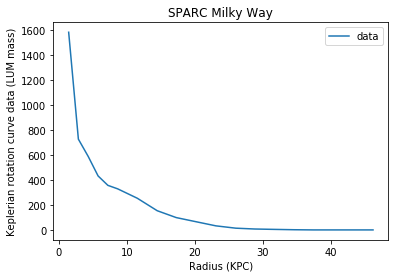

In [23]:
kpc = NGC5371[:,0]
vobs = NGC5371[:,6]
plt.plot(kpc, vobs)
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.xlabel('Radius (KPC)')
plt.ylabel('Keplerian rotation curve data (LUM mass)')
plt.title('SPARC Milky Way')
plt.show()

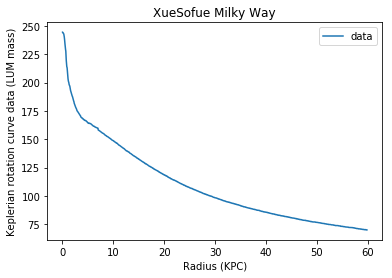

In [24]:
kpc = MWXueSofue[:,0]
vobs = MWXueSofue[:,1]
plt.plot(kpc, vobs)
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.xlabel('Radius (KPC)')
plt.ylabel('Keplerian rotation curve data (LUM mass)')
plt.title('XueSofue Milky Way')
plt.show()